<a href="https://colab.research.google.com/github/bmadnankece/ImageProcessingExercies/blob/master/lstm_tur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
4/4 [==============================] - 0s 10ms/step - loss: 11.0109
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 10.4121
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 9.9430
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 9.6104
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 8.8940
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 8.3460
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 7.1343
Epoch 8/100
4/4 [==============================] - 0s 11ms/step - loss: 7.5630
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 6.3634
Epoch 10/100
4/4 [==============================] - 0s 10ms/step - loss: 5.6657
Epoch 11/100
4/4 [==============================] - 0s 9ms/step - loss: 5.4485
Epoch 12/100
4/4 [==============================] - 0s 9ms/step - loss: 5.0863
Epoch 13/100
4/4 [==============================] - 0s

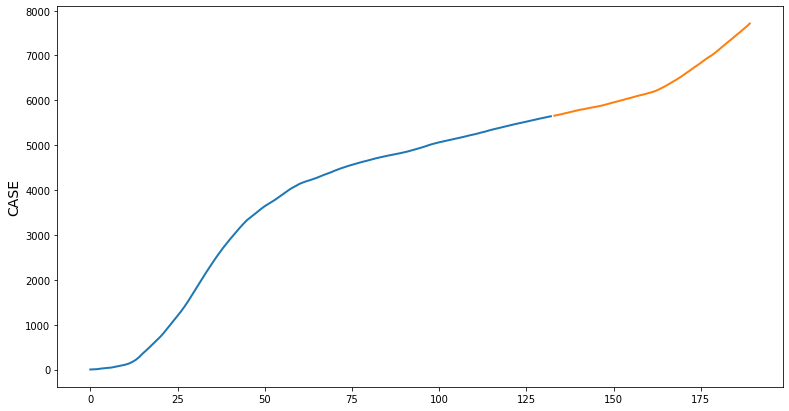

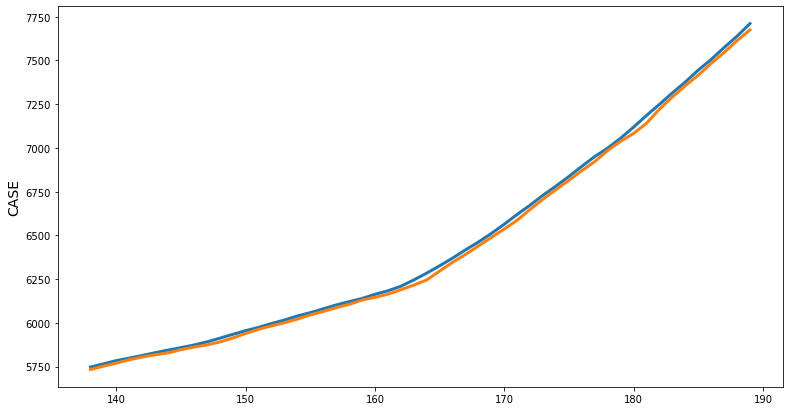

MAPE: 0.32055525874877466
 6086.689003
 6105.550003
 6130.151479
 6145.757361
 6163.434486
 6188.874456
 6215.892703
 6245.015217
 6295.907790
 6346.200795
 6390.722955
 6439.489212
 6488.151523
 6536.334058
 6586.910572
 6648.550622
 6707.321739
 6762.216504
 6814.871700
 6870.290151
 6922.375355
 6985.664502
 7037.951010
 7082.843569
 7141.267965
 7221.635153
 7291.820339
 7355.870041
 7416.101659
 7483.089752
 7545.870316
 7613.540766
 7675.141814


In [ ]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from google.colab import files

hist = pd.read_csv("/content/lstm_fat_tur.csv")
# hist = hist.set_index('date')
# hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'Fatalities'


def train_test_split(df, test_size=0.5):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data


train, test = train_test_split(hist, test_size=0.3)


def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('CASE', fontsize=14)
    ax.set_title(title, fontsize=16)


line_plot(train[target_col], test[target_col], 'training', 'test', title='')


def normalise_zero_base(df):
    return df / df.iloc[0] - 1


def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())


def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)


def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.3):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test


def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse',
                     optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model


np.random.seed(42)
window_len = 5
test_size = 0.3
zero_base = True
lstm_neurons = 200
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.3
optimizer = 'adam'

train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len,
                                                             zero_base=zero_base, test_size=test_size)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
# print(mean_squared_log_error(preds, y_test))
print("MAE:", mean_absolute_error(preds, y_test))

preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)
plt.show()


tf.keras.losses.MAPE(targets, preds)
mape_loss = 100 * np.mean(abs((targets - preds) / targets))
print("MAPE:", mape_loss)
print(preds.tail(n=33).to_string(index=False))
# print(preds.head)
